In [1]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
from sklearn.model_selection import StratifiedKFold

from ipyexperiments.ipyexperiments import IPyExperimentsPytorch
import timm,wandb,albumentations as A

from timm.data import Mixup
from timm.data.random_erasing import RandomErasing as RandomErasingTimm
from timm.loss import SoftTargetCrossEntropy
from timm.models import safe_model_name, set_fast_norm
from timm.models.layers import create_classifier, SelectAdaptivePool2d
from timm.models.layers.blur_pool import BlurPool2d

In [2]:
%env WANDB_SILENT=true
set_seed(42); set_fast_norm()
warnings.filterwarnings('ignore')

env: WANDB_SILENT=true


In [3]:
VERSION  = "NB_EXP_021"
EXP_NAME = f"{VERSION}_resnet50d"
MODEL_FOLDER = Path(f'/runs/{VERSION}'); os.makedirs(MODEL_FOLDER, exist_ok=True)

CSV_PATH     = Path('/data/train.csv')
DATA_PATH    = Path('/data/')
IMAGE_FOLDER = Path('/data/train/')

LABELS = sorted(['broken', 'pure', 'discolored', 'silkcut'])
labels_class_map = {v:k for k,v in enumerate(LABELS)}
labels_class_map_rev = {v:k for k,v in labels_class_map.items()}

VIEWS = sorted(['top', 'bottom'])
views_class_map = {v:k for k,v in enumerate(VIEWS)}
views_class_map_rev = {v:k for k,v in views_class_map.items()}

TIMM_MODEL = "resnet50d"

NFOLDS = 5
BS = 32
SZ = 224

TRAIN_AUG = A.Compose([
    A.Resize(SZ, SZ),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=360, border_mode=0, p=0.75),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    A.Blur(p=0.5),
    A.CoarseDropout(max_height=int(32*(SZ/512)), max_width=int(32*(SZ/512)), p=0.75), 
])

CROP_PCT = 1.0
SCALE_SZ = int(math.floor(SZ / CROP_PCT))
VALID_AUG = A.Compose([A.Resize(SCALE_SZ, SCALE_SZ), A.CenterCrop(SZ, SZ)])

In [4]:
all_df = pd.read_csv(CSV_PATH)

folds = all_df.copy()
fold_splits = []

Fold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=42)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds["label"])):
    fold_splits.append(val_index)
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)

folds.head()

,seed_id,view,image,label,fold
0,0,top,train/00000.png,broken,0
1,1,bottom,train/00001.png,pure,3
2,3,top,train/00003.png,broken,2
3,4,top,train/00004.png,pure,3
4,5,top,train/00005.png,discolored,4


In [5]:
@Transform
def hflip(x: TensorTypes): return x.flip(3)

@Transform
def vflip(x: TensorTypes): return x.flip(2)


class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0: aug_img = self.train_aug(image=np.array(img))['image']
        else            : aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [6]:
from timm.models.helpers import group_modules, group_parameters

def timm_get_module_names(m):
    modules_names = group_modules(m, m.group_matcher(coarse=True))
    return L(modules_names.values())[:-1] #cut timm head

def timm_get_param_names(m):
    param_names = group_parameters(m, m.group_matcher(coarse=True))
    return L(param_names.values())[:-1] #cut timm head

def timm_body_params(timm_model, cut=-1):
    param_names = timm_get_param_names(timm_model)
    return L(param_names[:cut].concat(), param_names[cut:].concat())

def timm_split(m, cut=-1):
    "Splitter function for timm models"
    timm_model, head = m[0].model, m[1]
    body_groups = [g.map(timm_model.get_parameter) for g in timm_body_params(timm_model, cut)]
    return body_groups + [params(head)]

In [7]:
def get_dls(fold:int, bs:int, *args, **kwargs):
    
    item_tfms = [ToTensor, AlbumentationsTransform(TRAIN_AUG, VALID_AUG)]
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    
    dblock = DataBlock(
        blocks     = (ImageBlock, CategoryBlock(vocab=LABELS)),
        splitter   = IndexSplitter(fold_splits[fold]),
        get_x      = ColReader('image', pref=DATA_PATH),
        get_y      = [ColReader('label')],
        item_tfms  = item_tfms,
        batch_tfms = batch_tfms )
    
    dls = dblock.dataloaders(folds, bs=bs)
    return dls

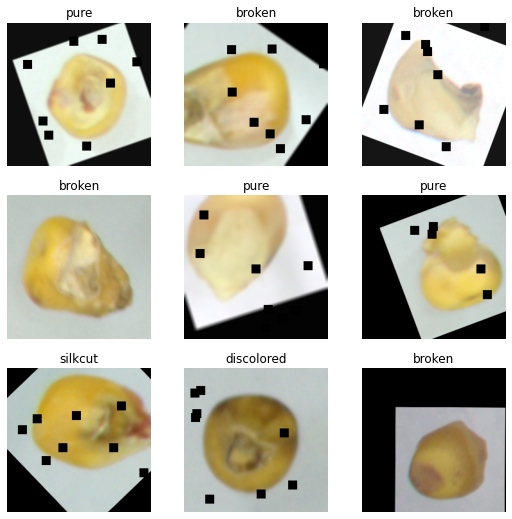

In [8]:
dls = get_dls(0, BS)
dls.show_batch()

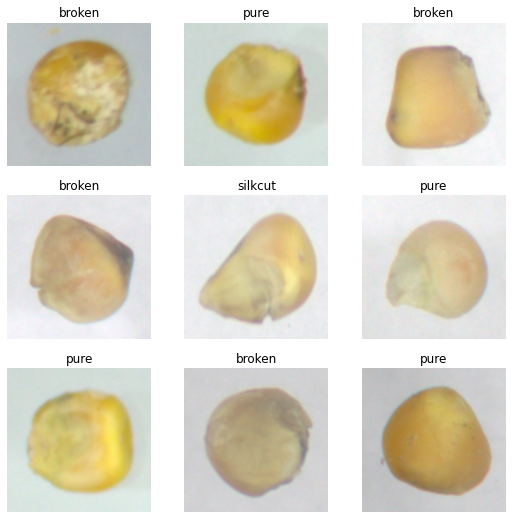

In [9]:
dls.valid.show_batch()

## adamw + fit_flat_cos

In [17]:
def build_experiment(fold:int = 0, pretrained:bool=True):
    print(f'model:{TIMM_MODEL}; pretrained:{pretrained}')
    print(f'fold:{fold}; sz:{SZ}; bs:{BS}')
    
    dls = get_dls(fold, bs=BS)
    
    learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=pretrained,
                           loss_func=CrossEntropyLossFlat(), metrics=[accuracy],
                           act_layer=nn.Mish).to_fp16()
    return dls, learn


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

model:resnet50d; pretrained:True
fold:0; sz:224; bs:32


SuggestedLRs(valley=0.0004786300996784121, slide=0.004365158267319202)
CPU: 36/89/3354 MB | GPU: -104/2166/1996 MB | Time 0:00:06.351 | (Consumed/Peaked/Used Total)


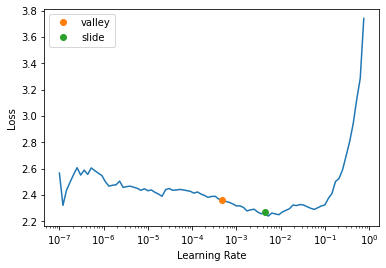

In [18]:
with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):      
    dls, learn = build_experiment(0)
    print(learn.lr_find(suggest_funcs=(valley, slide)))

In [20]:
n_epo = 20; base_lr = 0.004;
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_mixup"

In [21]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, 
                        save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
            
            print()
            print('*' * 100)
            print(f'Training fold {fold_idx}')
            print('*' * 100)
        
            dls, learn = build_experiment(fold_idx)
            print(f'epochs:{n_epo}; base_lr:{base_lr}')
            
            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),
                   MixUp(0.4), WandbCallback(log_preds=None)]
            
            learn.unfreeze()
            learn.fit_flat_cos(n_epo, slice(base_lr/10,base_lr), cbs=cbs)
            
            #learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 0
****************************************************************************************************
model:resnet50d; pretrained:True
fold:0; sz:224; bs:32
epochs:20; base_lr:0.004


epoch,train_loss,valid_loss,accuracy,time
0,1.105352,0.831628,0.667016,00:28
1,1.060517,0.794776,0.689005,00:28
2,0.971000,0.719566,0.729843,00:28
3,0.928151,0.699050,0.734380,00:28
4,0.905837,0.661850,0.730890,00:29
5,0.913850,0.685516,0.737871,00:29
6,0.862051,0.643322,0.747993,00:29
7,0.841011,0.582423,0.768586,00:29
8,0.825811,0.573100,0.770681,00:29
9,0.837647,0.603624,0.760558,00:29


Better model found at epoch 0 with accuracy value: 0.6670157313346863.
Better model found at epoch 1 with accuracy value: 0.6890052556991577.
Better model found at epoch 2 with accuracy value: 0.7298429608345032.
Better model found at epoch 3 with accuracy value: 0.7343804240226746.
Better model found at epoch 5 with accuracy value: 0.7378708720207214.
Better model found at epoch 6 with accuracy value: 0.747992992401123.
Better model found at epoch 7 with accuracy value: 0.7685863971710205.
Better model found at epoch 8 with accuracy value: 0.7706806063652039.
Better model found at epoch 14 with accuracy value: 0.7766143083572388.
Better model found at epoch 15 with accuracy value: 0.7860383987426758.
Better model found at epoch 17 with accuracy value: 0.7877836227416992.
Better model found at epoch 18 with accuracy value: 0.8031413555145264.
CPU: 259/77/3614 MB | GPU: 1194/1454/3190 MB | Time 0:10:01.423 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
D


****************************************************************************************************
Training fold 1
****************************************************************************************************
model:resnet50d; pretrained:True
fold:1; sz:224; bs:32
epochs:20; base_lr:0.004


epoch,train_loss,valid_loss,accuracy,time
0,1.101453,0.847879,0.669808,00:29
1,1.013975,0.737326,0.706806,00:29
2,0.948731,0.756369,0.706806,00:29
3,0.934198,0.700050,0.721117,00:29
4,0.881144,0.648450,0.750436,00:29
5,0.860393,0.590513,0.761606,00:29
6,0.845395,0.590759,0.762653,00:29
7,0.835668,0.570429,0.774171,00:29
8,0.817183,0.600444,0.763351,00:29
9,0.841236,0.573443,0.775567,00:29


Better model found at epoch 0 with accuracy value: 0.669808030128479.
Better model found at epoch 1 with accuracy value: 0.7068063020706177.
Better model found at epoch 3 with accuracy value: 0.7211169004440308.
Better model found at epoch 4 with accuracy value: 0.7504363059997559.
Better model found at epoch 5 with accuracy value: 0.7616055607795715.
Better model found at epoch 6 with accuracy value: 0.7626526951789856.
Better model found at epoch 7 with accuracy value: 0.7741710543632507.
Better model found at epoch 9 with accuracy value: 0.7755671739578247.
Better model found at epoch 12 with accuracy value: 0.7804537415504456.
Better model found at epoch 14 with accuracy value: 0.7867364883422852.
Better model found at epoch 17 with accuracy value: 0.7912740111351013.
Better model found at epoch 18 with accuracy value: 0.8052356243133545.
CPU: -77/100/3536 MB | GPU: -82/1744/3108 MB | Time 0:10:09.044 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
D


****************************************************************************************************
Training fold 2
****************************************************************************************************
model:resnet50d; pretrained:True
fold:2; sz:224; bs:32
epochs:20; base_lr:0.004


epoch,train_loss,valid_loss,accuracy,time
0,1.130084,0.853308,0.653980,00:29
1,1.007579,0.796537,0.664455,00:29
2,1.011572,0.827581,0.688897,00:29
3,0.903270,0.683098,0.728352,00:29
4,0.913332,0.700097,0.717877,00:29
5,0.883263,0.640240,0.747556,00:29
6,0.850966,0.640706,0.756983,00:29
7,0.836258,0.600732,0.762919,00:29
8,0.828820,0.587599,0.763617,00:29
9,0.830861,0.596641,0.762570,00:30


Better model found at epoch 0 with accuracy value: 0.6539804339408875.
Better model found at epoch 1 with accuracy value: 0.6644552946090698.
Better model found at epoch 2 with accuracy value: 0.688896656036377.
Better model found at epoch 3 with accuracy value: 0.7283519506454468.
Better model found at epoch 5 with accuracy value: 0.7475558519363403.
Better model found at epoch 6 with accuracy value: 0.75698322057724.
Better model found at epoch 7 with accuracy value: 0.762919008731842.
Better model found at epoch 8 with accuracy value: 0.7636173367500305.
Better model found at epoch 10 with accuracy value: 0.7740921974182129.
Better model found at epoch 11 with accuracy value: 0.7800279259681702.
Better model found at epoch 17 with accuracy value: 0.7877094745635986.
Better model found at epoch 18 with accuracy value: 0.7932960987091064.
Better model found at epoch 19 with accuracy value: 0.7939944267272949.
CPU: 100/82/3636 MB | GPU: 206/1606/3314 MB | Time 0:10:12.747 | (Consumed/P


****************************************************************************************************
Training fold 3
****************************************************************************************************
model:resnet50d; pretrained:True
fold:3; sz:224; bs:32
epochs:20; base_lr:0.004


epoch,train_loss,valid_loss,accuracy,time
0,1.133594,0.793230,0.673883,00:29
1,1.000805,0.797736,0.675279,00:29
2,0.959243,0.679325,0.721718,00:29
3,0.911142,0.699501,0.723813,00:29
4,0.894149,0.620660,0.747905,00:29
5,0.877687,0.626567,0.748254,00:29
6,0.861560,0.611387,0.757332,00:29
7,0.845546,0.609851,0.758031,00:29
8,0.834515,0.580872,0.771997,00:29
9,0.814443,0.571301,0.775489,00:29


Better model found at epoch 0 with accuracy value: 0.6738826632499695.
Better model found at epoch 1 with accuracy value: 0.6752793192863464.
Better model found at epoch 2 with accuracy value: 0.721717894077301.
Better model found at epoch 3 with accuracy value: 0.7238128781318665.
Better model found at epoch 4 with accuracy value: 0.7479050159454346.
Better model found at epoch 5 with accuracy value: 0.7482541799545288.
Better model found at epoch 6 with accuracy value: 0.7573323845863342.
Better model found at epoch 7 with accuracy value: 0.7580307126045227.
Better model found at epoch 8 with accuracy value: 0.7719972133636475.
Better model found at epoch 9 with accuracy value: 0.7754888534545898.
Better model found at epoch 11 with accuracy value: 0.7800279259681702.
Better model found at epoch 12 with accuracy value: 0.7807262539863586.
Better model found at epoch 14 with accuracy value: 0.7960894107818604.
Better model found at epoch 17 with accuracy value: 0.8041201233863831.
Bet


****************************************************************************************************
Training fold 4
****************************************************************************************************
model:resnet50d; pretrained:True
fold:4; sz:224; bs:32
epochs:20; base_lr:0.004


epoch,train_loss,valid_loss,accuracy,time
0,1.143722,1.140633,0.618715,00:29
1,1.047146,0.755517,0.723115,00:29
2,0.954922,0.698398,0.719623,00:29
3,0.924564,0.648254,0.743017,00:29
4,0.869145,0.584876,0.769204,00:29
5,0.902589,0.600983,0.755237,00:29
6,0.853948,0.635780,0.739525,00:29
7,0.830935,0.590622,0.763268,00:29
8,0.827101,0.586630,0.771299,00:29
9,0.837913,0.553190,0.787011,00:29


Better model found at epoch 0 with accuracy value: 0.6187151074409485.
Better model found at epoch 1 with accuracy value: 0.723114550113678.
Better model found at epoch 3 with accuracy value: 0.74301677942276.
Better model found at epoch 4 with accuracy value: 0.7692039012908936.
Better model found at epoch 8 with accuracy value: 0.771298885345459.
Better model found at epoch 9 with accuracy value: 0.7870111465454102.
Better model found at epoch 11 with accuracy value: 0.7929469347000122.
Better model found at epoch 14 with accuracy value: 0.7936452627182007.
Better model found at epoch 16 with accuracy value: 0.8009776473045349.
Better model found at epoch 17 with accuracy value: 0.8065642714500427.
Better model found at epoch 18 with accuracy value: 0.8093575239181519.
Better model found at epoch 19 with accuracy value: 0.8149441480636597.
CPU: 78/78/3639 MB | GPU: -212/1514/3200 MB | Time 0:10:15.484 | (Consumed/Peaked/Used Total)


In [22]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        
        dls, learn = build_experiment(fold_index, pretrained=False)
        learn.model_dir = Path(MODEL_FOLDER)
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"==> Load checkpoint from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # no augs
        tst_dl = dls.valid.new()
        
        # hflip augs
        tst_dl_hflip = dls.valid.new()
        tst_dl_hflip.after_batch.add(hflip)
        
        # vflip augs
        tst_dl_vflip = dls.valid.new()
        tst_dl_vflip.after_batch.add(vflip)
        
#         # hflip + vflip augs
#         tst_dl_hlip_vflip = dls.valid.new()
#         tst_dl_hlip_vflip.after_batch.add([hflip,vflip])
            
        dls = [tst_dl,tst_dl_hflip,tst_dl_vflip]
        n = len(dls)
        learn([event.before_fit, event.before_epoch])
        
        aug_preds = []
        with learn.no_mbar():
            if hasattr(learn,'progress'): learn.progress.mbar = master_bar(list(range(n)))
            
            for i in learn.progress.mbar if hasattr(learn,'progress') else range(n):
                learn.epoch = i
                with dls[i].dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dls[i], inner=True)
                aug_preds.append(preds[None])
        
        learn.epoch = n
        
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.mean(0)
        acc = accuracy(aug_preds, targs).item()
        print(f"* Accuracy : {acc}")
        print()
        
        folds_val_score.append(acc)
        learn(event.after_fit)
        
           
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

model:resnet50d; pretrained:False
fold:0; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_resnet50d_224_bs32_epo20_mixup_CV_00' (00)


* Accuracy : 0.8052356243133545

model:resnet50d; pretrained:False
fold:1; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_resnet50d_224_bs32_epo20_mixup_CV_01' (01)


* Accuracy : 0.8027923107147217

model:resnet50d; pretrained:False
fold:2; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_resnet50d_224_bs32_epo20_mixup_CV_02' (02)


* Accuracy : 0.80551677942276

model:resnet50d; pretrained:False
fold:3; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_resnet50d_224_bs32_epo20_mixup_CV_03' (03)


* Accuracy : 0.818086564540863

model:resnet50d; pretrained:False
fold:4; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_resnet50d_224_bs32_epo20_mixup_CV_04' (04)


* Accuracy : 0.8149441480636597

CPU: -86/8/3553 MB | GPU: -1156/202/2044 MB | Time 0:00:44.183 | (Consumed/Peaked/Used Total)

****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.80524, 0.80279, 0.80552, 0.81809, 0.81494]
Avg: 0.80932
Std: 0.00604


In [23]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        
        dls, learn = build_experiment(fold_index, pretrained=False)
        learn.model_dir = Path(MODEL_FOLDER)
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"==> Load checkpoint from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # no augs
        tst_dl = dls.valid.new()
        
        # hflip augs
        tst_dl_hflip = dls.valid.new()
        tst_dl_hflip.after_batch.add(hflip)
        
        # vflip augs
        tst_dl_vflip = dls.valid.new()
        tst_dl_vflip.after_batch.add(vflip)
        
        # hflip + vflip augs
        tst_dl_hlip_vflip = dls.valid.new()
        tst_dl_hlip_vflip.after_batch.add([hflip,vflip])
            
        dls = [tst_dl,tst_dl_hflip,tst_dl_vflip,tst_dl_hlip_vflip]
        n = len(dls)
        learn([event.before_fit, event.before_epoch])
        
        aug_preds = []
        with learn.no_mbar():
            if hasattr(learn,'progress'): learn.progress.mbar = master_bar(list(range(n)))
            
            for i in learn.progress.mbar if hasattr(learn,'progress') else range(n):
                learn.epoch = i
                with dls[i].dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dls[i], inner=True)
                aug_preds.append(preds[None])
        
        learn.epoch = n
        
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.mean(0)
        acc = accuracy(aug_preds, targs).item()
        print(f"* Accuracy : {acc}")
        print()
        
        folds_val_score.append(acc)
        learn(event.after_fit)
        
           
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

model:resnet50d; pretrained:False
fold:0; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_resnet50d_224_bs32_epo20_mixup_CV_00' (00)


* Accuracy : 0.8062826991081238

model:resnet50d; pretrained:False
fold:1; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_resnet50d_224_bs32_epo20_mixup_CV_01' (01)


* Accuracy : 0.8038394451141357

model:resnet50d; pretrained:False
fold:2; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_resnet50d_224_bs32_epo20_mixup_CV_02' (02)


* Accuracy : 0.8072625994682312

model:resnet50d; pretrained:False
fold:3; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_resnet50d_224_bs32_epo20_mixup_CV_03' (03)


* Accuracy : 0.8170391321182251

model:resnet50d; pretrained:False
fold:4; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_resnet50d_224_bs32_epo20_mixup_CV_04' (04)


* Accuracy : 0.8149441480636597

CPU: 8/76/3561 MB | GPU: 0/882/2044 MB | Time 0:00:58.154 | (Consumed/Peaked/Used Total)

****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.80628, 0.80384, 0.80726, 0.81704, 0.81494]
Avg: 0.80987
Std: 0.00516


## ranger + fit_flat_cos

In [11]:
def build_experiment(fold:int = 0, pretrained:bool=True):
    print(f'model:{TIMM_MODEL}; pretrained:{pretrained}')
    print(f'fold:{fold}; sz:{SZ}; bs:{BS}')
    
    dls = get_dls(fold, bs=BS)
    
    learn = vision_learner(dls, TIMM_MODEL, n_out=dls.c, pretrained=pretrained,
                           loss_func=CrossEntropyLossFlat(), metrics=[accuracy],
                           act_layer=nn.Mish, opt_func=ranger).to_fp16()
    return dls, learn


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

model:resnet50d; pretrained:True
fold:0; sz:224; bs:32


SuggestedLRs(valley=0.0020892962347716093, slide=0.010964781977236271)
CPU: 1872/0/3301 MB | GPU: 914/2338/1970 MB | Time 0:00:07.654 | (Consumed/Peaked/Used Total)


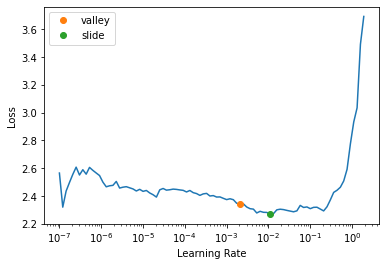

In [12]:
with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):      
    dls, learn = build_experiment(0)
    print(learn.lr_find(suggest_funcs=(valley, slide)))

In [13]:
learn.opt_func

<function fastai.optimizer.ranger(p, lr, mom=0.95, wd=0.01, eps=1e-06, *, sqr_mom=0.99, beta=0.0, decouple_wd=True)>

In [14]:
VERSION  = "NB_EXP_021_v2"
EXP_NAME = f"{VERSION}_resnet50d"
MODEL_FOLDER = Path(f'/runs/{VERSION}'); os.makedirs(MODEL_FOLDER, exist_ok=True)
n_epo = 20; base_lr = 0.01;
SUFFIX = f"{SZ}_bs{BS}_epo{n_epo}_mixup"

In [15]:
for fold_idx in range(NFOLDS):
    with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
        
        with wandb.init(project='pog3_corn',
                        group=EXP_NAME, 
                        save_code=True,
                        name=f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'):
            
            print()
            print('*' * 100)
            print(f'Training fold {fold_idx}')
            print('*' * 100)
        
            dls, learn = build_experiment(fold_idx)
            print(f'epochs:{n_epo}; base_lr:{base_lr}')
            
            cbs = [SaveModelCallback(monitor="accuracy", comp=np.greater),
                   MixUp(0.4), WandbCallback(log_preds=None)]
            
            learn.unfreeze()
            learn.fit_flat_cos(n_epo, slice(base_lr/100,base_lr), cbs=cbs)
            
            #learn.fine_tune(n_epo, base_lr, cbs=cbs)

            learn = learn.load("model")
            learn = learn.to_fp32()

            dirpath = MODEL_FOLDER/f'{EXP_NAME}_{SUFFIX}_CV_{fold_idx:02d}'
            learn.save(dirpath, with_opt=False)


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)


****************************************************************************************************
Training fold 0
****************************************************************************************************
model:resnet50d; pretrained:True
fold:0; sz:224; bs:32
epochs:20; base_lr:0.01


epoch,train_loss,valid_loss,accuracy,time
0,1.218323,0.931212,0.625131,00:29
1,1.113141,0.879783,0.650611,00:29
2,1.016897,0.783044,0.679581,00:29
3,0.930006,0.676039,0.726702,00:29
4,0.901285,0.622106,0.743455,00:29
5,0.873479,0.612292,0.757766,00:29
6,0.851532,0.598269,0.764049,00:29
7,0.823239,0.573210,0.773473,00:29
8,0.803929,0.553652,0.777312,00:29
9,0.814937,0.549325,0.783944,00:29


Better model found at epoch 0 with accuracy value: 0.6251308917999268.
Better model found at epoch 1 with accuracy value: 0.6506108045578003.
Better model found at epoch 2 with accuracy value: 0.6795811653137207.
Better model found at epoch 3 with accuracy value: 0.726701557636261.
Better model found at epoch 4 with accuracy value: 0.7434554696083069.
Better model found at epoch 5 with accuracy value: 0.7577661275863647.
Better model found at epoch 6 with accuracy value: 0.7640488743782043.
Better model found at epoch 7 with accuracy value: 0.7734729647636414.
Better model found at epoch 8 with accuracy value: 0.7773123979568481.
Better model found at epoch 9 with accuracy value: 0.7839441299438477.
Better model found at epoch 14 with accuracy value: 0.7905759215354919.
CPU: 359/81/3632 MB | GPU: 1130/1556/3100 MB | Time 0:10:15.450 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 1
****************************************************************************************************
model:resnet50d; pretrained:True
fold:1; sz:224; bs:32
epochs:20; base_lr:0.01


epoch,train_loss,valid_loss,accuracy,time
0,1.220976,0.862592,0.642583,00:29
1,1.099745,0.842001,0.651658,00:30
2,0.972899,0.683546,0.724956,00:30
3,0.948232,0.659536,0.738918,00:30
4,0.883567,0.616945,0.757417,00:30
5,0.846458,0.571668,0.774520,00:29
6,0.826256,0.560151,0.779756,00:30
7,0.828826,0.543569,0.790576,00:30
8,0.799244,0.540664,0.785340,00:30
9,0.821207,0.535078,0.788482,00:30


Better model found at epoch 0 with accuracy value: 0.642582893371582.
Better model found at epoch 1 with accuracy value: 0.6516579389572144.
Better model found at epoch 2 with accuracy value: 0.7249563932418823.
Better model found at epoch 3 with accuracy value: 0.7389179468154907.
Better model found at epoch 4 with accuracy value: 0.7574170827865601.
Better model found at epoch 5 with accuracy value: 0.7745200991630554.
Better model found at epoch 6 with accuracy value: 0.7797556519508362.
Better model found at epoch 7 with accuracy value: 0.7905759215354919.
Better model found at epoch 11 with accuracy value: 0.7958115339279175.
Better model found at epoch 14 with accuracy value: 0.8041884899139404.
Better model found at epoch 17 with accuracy value: 0.8062826991081238.
CPU: 25/83/3658 MB | GPU: 28/1918/3128 MB | Time 0:10:19.640 | (Consumed/Peaked/Used Total)

*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)




****************************************************************************************************
Training fold 2
****************************************************************************************************
model:resnet50d; pretrained:True
fold:2; sz:224; bs:32
epochs:20; base_lr:0.01


epoch,train_loss,valid_loss,accuracy,time
0,1.245880,0.859437,0.647346,00:29
1,1.100049,0.762894,0.686453,00:30
2,1.005463,0.763940,0.694483,00:30
3,0.927301,0.665611,0.730447,00:30
4,0.888559,0.625918,0.746159,00:30
5,0.861174,0.611892,0.755936,00:29
6,0.829343,0.580709,0.769553,00:30
7,0.812256,0.567370,0.769204,00:30
8,0.805443,0.565487,0.773045,00:30
9,0.816333,0.555348,0.785964,00:30


Better model found at epoch 0 with accuracy value: 0.6473463773727417.
Better model found at epoch 1 with accuracy value: 0.6864525079727173.
Better model found at epoch 2 with accuracy value: 0.69448322057724.
Better model found at epoch 3 with accuracy value: 0.7304469347000122.
Better model found at epoch 4 with accuracy value: 0.7461591958999634.
Better model found at epoch 5 with accuracy value: 0.7559357285499573.
Better model found at epoch 6 with accuracy value: 0.7695530652999878.
Better model found at epoch 8 with accuracy value: 0.7730447053909302.
Better model found at epoch 9 with accuracy value: 0.7859637141227722.
Better model found at epoch 10 with accuracy value: 0.7891061305999756.
Better model found at epoch 12 with accuracy value: 0.7915502786636353.
Better model found at epoch 13 with accuracy value: 0.7978351712226868.
Better model found at epoch 19 with accuracy value: 0.7985334992408752.
CPU: 6/83/3664 MB | GPU: 133/1772/3262 MB | Time 0:10:19.847 | (Consumed/Pe


****************************************************************************************************
Training fold 3
****************************************************************************************************
model:resnet50d; pretrained:True
fold:3; sz:224; bs:32
epochs:20; base_lr:0.01


epoch,train_loss,valid_loss,accuracy,time
0,1.227740,0.944648,0.584497,00:30
1,1.103804,0.850263,0.661662,00:30
2,1.008100,0.698387,0.721020,00:30
3,0.921988,0.653633,0.740223,00:30
4,0.891391,0.603072,0.768506,00:29
5,0.880426,0.611123,0.762570,00:30
6,0.856658,0.576209,0.774441,00:30
7,0.841922,0.558535,0.788059,00:30
8,0.825320,0.534187,0.789106,00:30
9,0.796888,0.525725,0.791550,00:30


Better model found at epoch 0 with accuracy value: 0.5844972133636475.
Better model found at epoch 1 with accuracy value: 0.6616619825363159.
Better model found at epoch 2 with accuracy value: 0.7210195660591125.
Better model found at epoch 3 with accuracy value: 0.7402234673500061.
Better model found at epoch 4 with accuracy value: 0.7685055732727051.
Better model found at epoch 6 with accuracy value: 0.7744413614273071.
Better model found at epoch 7 with accuracy value: 0.7880586385726929.
Better model found at epoch 8 with accuracy value: 0.7891061305999756.
Better model found at epoch 9 with accuracy value: 0.7915502786636353.
Better model found at epoch 10 with accuracy value: 0.7918994426727295.
Better model found at epoch 12 with accuracy value: 0.8002793192863464.
Better model found at epoch 13 with accuracy value: 0.806913435459137.
Better model found at epoch 14 with accuracy value: 0.8086591958999634.
Better model found at epoch 17 with accuracy value: 0.8114525079727173.
Be


****************************************************************************************************
Training fold 4
****************************************************************************************************
model:resnet50d; pretrained:True
fold:4; sz:224; bs:32
epochs:20; base_lr:0.01


epoch,train_loss,valid_loss,accuracy,time
0,1.218060,1.145869,0.573673,00:29
1,1.109774,0.795389,0.675978,00:30
2,0.977261,0.698572,0.721369,00:30
3,0.947409,0.621145,0.757682,00:30
4,0.881075,0.598816,0.755936,00:30
5,0.887100,0.565783,0.775489,00:30
6,0.838401,0.577614,0.773045,00:30
7,0.841107,0.555294,0.784218,00:30
8,0.817236,0.559990,0.788408,00:30
9,0.825828,0.530324,0.795391,00:30


Better model found at epoch 0 with accuracy value: 0.5736731886863708.
Better model found at epoch 1 with accuracy value: 0.6759776473045349.
Better model found at epoch 2 with accuracy value: 0.7213687300682068.
Better model found at epoch 3 with accuracy value: 0.7576815485954285.
Better model found at epoch 5 with accuracy value: 0.7754888534545898.
Better model found at epoch 7 with accuracy value: 0.784217894077301.
Better model found at epoch 8 with accuracy value: 0.7884078025817871.
Better model found at epoch 9 with accuracy value: 0.7953910827636719.
Better model found at epoch 11 with accuracy value: 0.7964385747909546.
Better model found at epoch 15 with accuracy value: 0.7999301552772522.
Better model found at epoch 16 with accuracy value: 0.8048184514045715.
Better model found at epoch 17 with accuracy value: 0.8065642714500427.
Better model found at epoch 19 with accuracy value: 0.8104050159454346.
CPU: 2/78/3667 MB | GPU: 158/1482/3564 MB | Time 0:10:24.673 | (Consumed/

In [16]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        
        dls, learn = build_experiment(fold_index, pretrained=False)
        learn.model_dir = Path(MODEL_FOLDER)
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"==> Load checkpoint from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # no augs
        tst_dl = dls.valid.new()
        
        # hflip augs
        tst_dl_hflip = dls.valid.new()
        tst_dl_hflip.after_batch.add(hflip)
        
        # vflip augs
        tst_dl_vflip = dls.valid.new()
        tst_dl_vflip.after_batch.add(vflip)
        
#         # hflip + vflip augs
#         tst_dl_hlip_vflip = dls.valid.new()
#         tst_dl_hlip_vflip.after_batch.add([hflip,vflip])
            
        dls = [tst_dl,tst_dl_hflip,tst_dl_vflip]
        n = len(dls)
        learn([event.before_fit, event.before_epoch])
        
        aug_preds = []
        with learn.no_mbar():
            if hasattr(learn,'progress'): learn.progress.mbar = master_bar(list(range(n)))
            
            for i in learn.progress.mbar if hasattr(learn,'progress') else range(n):
                learn.epoch = i
                with dls[i].dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dls[i], inner=True)
                aug_preds.append(preds[None])
        
        learn.epoch = n
        
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.mean(0)
        acc = accuracy(aug_preds, targs).item()
        print(f"* Accuracy : {acc}")
        print()
        
        folds_val_score.append(acc)
        learn(event.after_fit)
        
           
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

model:resnet50d; pretrained:False
fold:0; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_v2_resnet50d_224_bs32_epo20_mixup_CV_00' (00)


* Accuracy : 0.8013961315155029

model:resnet50d; pretrained:False
fold:1; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_v2_resnet50d_224_bs32_epo20_mixup_CV_01' (01)


* Accuracy : 0.8097731471061707

model:resnet50d; pretrained:False
fold:2; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_v2_resnet50d_224_bs32_epo20_mixup_CV_02' (02)


* Accuracy : 0.8027234673500061

model:resnet50d; pretrained:False
fold:3; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_v2_resnet50d_224_bs32_epo20_mixup_CV_03' (03)


* Accuracy : 0.8201815485954285

model:resnet50d; pretrained:False
fold:4; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_v2_resnet50d_224_bs32_epo20_mixup_CV_04' (04)


* Accuracy : 0.8114525079727173

CPU: 2/4/3669 MB | GPU: -1388/198/2176 MB | Time 0:00:44.808 | (Consumed/Peaked/Used Total)

****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.8014, 0.80977, 0.80272, 0.82018, 0.81145]
Avg: 0.80911
Std: 0.00676


In [18]:
pattern = f'{EXP_NAME}_{SUFFIX}_CV_' + '{fold:02d}'
folds_val_score = []

with IPyExperimentsPytorch(exp_enable=False, cl_set_seed=42, cl_compact=True):
    
    for fold_index in range(NFOLDS):
        
        dls, learn = build_experiment(fold_index, pretrained=False)
        learn.model_dir = Path(MODEL_FOLDER)
        
        checkpoint = pattern.format(fold=fold_index)
        print(f"==> Load checkpoint from : {checkpoint!r} ({fold_index:02d})")
        
        learn.load(checkpoint)
        
        # no augs
        tst_dl = dls.valid.new()
        
        # hflip augs
        tst_dl_hflip = dls.valid.new()
        tst_dl_hflip.after_batch.add(hflip)
        
        # vflip augs
        tst_dl_vflip = dls.valid.new()
        tst_dl_vflip.after_batch.add(vflip)
        
        # hflip + vflip augs
        tst_dl_hlip_vflip = dls.valid.new()
        tst_dl_hlip_vflip.after_batch.add([hflip,vflip])
            
        dls = [tst_dl,tst_dl_hflip,tst_dl_vflip,tst_dl_hlip_vflip]
        n = len(dls)
        learn([event.before_fit, event.before_epoch])
        
        aug_preds = []
        with learn.no_mbar():
            if hasattr(learn,'progress'): learn.progress.mbar = master_bar(list(range(n)))
            
            for i in learn.progress.mbar if hasattr(learn,'progress') else range(n):
                learn.epoch = i
                with dls[i].dataset.set_split_idx(1): preds,targs = learn.get_preds(dl=dls[i], inner=True)
                aug_preds.append(preds[None])
        
        learn.epoch = n
        
        aug_preds = torch.cat(aug_preds)
        aug_preds = aug_preds.mean(0)
        acc = accuracy(aug_preds, targs).item()
        print(f"* Accuracy : {acc}")
        print()
        
        folds_val_score.append(acc)
        learn(event.after_fit)
        
           
print()
print('*' * 100)
print(f'Run summary: ')
print('*' * 100)
print("folds score: ", [np.round(s, 5) for s in folds_val_score])
print("Avg: {:.5f}".format(np.mean(folds_val_score)))
print("Std: {:.5f}".format(np.std(folds_val_score)))


*** Experiment started with the Pytorch backend
Device: ID 0, NVIDIA GeForce RTX 3090 (24576 RAM)

model:resnet50d; pretrained:False
fold:0; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_v2_resnet50d_224_bs32_epo20_mixup_CV_00' (00)


* Accuracy : 0.8048865795135498

model:resnet50d; pretrained:False
fold:1; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_v2_resnet50d_224_bs32_epo20_mixup_CV_01' (01)


* Accuracy : 0.8104711771011353

model:resnet50d; pretrained:False
fold:2; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_v2_resnet50d_224_bs32_epo20_mixup_CV_02' (02)


* Accuracy : 0.8020251393318176

model:resnet50d; pretrained:False
fold:3; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_v2_resnet50d_224_bs32_epo20_mixup_CV_03' (03)


* Accuracy : 0.8198323845863342

model:resnet50d; pretrained:False
fold:4; sz:224; bs:32
==> Load checkpoint from : 'NB_EXP_021_v2_resnet50d_224_bs32_epo20_mixup_CV_04' (04)


* Accuracy : 0.8097066879272461

CPU: 6/7/3697 MB | GPU: 720/308/2890 MB | Time 0:00:57.726 | (Consumed/Peaked/Used Total)

****************************************************************************************************
Run summary: 
****************************************************************************************************
folds score:  [0.80489, 0.81047, 0.80203, 0.81983, 0.80971]
Avg: 0.80938
Std: 0.00608
